<img src="https://i.imgur.com/9utPGpa.png">

<center><h1> Determining a Pokemon's Type</h1> <h2>CMSC320 Final Tutorial</h2>
<h4>Group Members: Prathamesh Kotgire & Ayyub Ahmed</h4></center>

<h2>Introduction</h2>
<p>
Pokemon is a very popular game that has been around since 1996. It is created by GameFreak and is exclusive to Nintendo consoles. It has evolved greatly over the years and has also increased in popularity due to the release of the mobile game Pokemon Go. The latest main series pokemon games, "Pokemon Ultra Sun" and "Pokemon Ultra Moon," sold over 1 million copies in just the first 3 days after its release. 
</p>
<p>
The main goal of the pokemon games is to construct a team of 6 pokemon with which you would fight other opponents' teams with. A pokemon is a creature that has many attributes and skills that makes it useful for fighting other pokemon. Some of the more defining characteristics of a Pokemon are its' <a href="https://bulbapedia.bulbagarden.net/wiki/Statistic">stats</a>, <a href="http://pokemon.wikia.com/wiki/Types">type</a>, height, weight, <a href="https://bulbapedia.bulbagarden.net/wiki/Catch_rate">catch rate</a>, and gender ratios. A pokemons stats determine how strong it will be in a battle. The higher the stat in an area, the stronger the pokemon is in that area. A pokemon's type referes to the elemental property it is associated with. A pokemon's catch rate determines how hard the pokemon will be to catch in the wild. The lower the value, the harder it is to catch. Although a Pokemon may have many more characteristics, these are the ones that we will be focusing on. 
</p>
<p>
Our goal is to see if there is a way to determine what a Pokemon's type is given its other characteristics. Our Null Hypothesis is that there is no correlation between a Pokemon and its' attributes. This guide will be a step by step tutorial walking you through the data pipeline. We will be scraping data, tidying it, analyzing it, and training a machine learning algorithm. We hope that people can use this tutorial as a basis to do even further and more complex analysis on the pokemon data.
</p>

<h2> Part 1: Data Collection & Data Processing</h2>

<h3> Required Libraries </h3>

You must have the following libraries installed: <br><br>
<a href="https://pandas.pydata.org/about.html">Pandas</a> <br>
<a href="http://www.numpy.org/">Numpy</a> <br>
<a href="https://matplotlib.org/">Matplotlib</a> <br>
<a href="https://seaborn.pydata.org/">Seaborn</a> <br>
<a href="http://docs.python-requests.org/en/master/">Requests</a> <br>
<a href="http://scikit-learn.org/stable/">Sklearn</a> <br>
<a href="http://www.statsmodels.org/stable/index.html">StatsModels</a> <br>
<a href="https://www.crummy.com/software/BeautifulSoup/">BeautifulSoup</a> <br>

For more information about each library, you can click on its' respective link. <br>
Below is the code to import each of these libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os.path
import sklearn
import statsmodels.api as sm
from sklearn import *
from sklearn.model_selection import KFold
from bs4 import BeautifulSoup as bs

<h3> Scraping - Part 1</h3>

We will start off by getting the data for each Pokemon's stats. The stat data would consist of a Pokemon's total stat value, hp, attack, defense, special attack, special defense, and speed. <a href="https://pokemondb.net/pokedex/all">Pokemon Database</a> conveniently has the stat values for each pokemon as well as its name and ID.

We will first use Requests to obtain the HTML text from the source: https://pokemondb.net/pokedex/all. Then we will use BeautifulSoup to parse this text more easily. After the text is prettified, we take the infromation from the HTML tables and insert it into a Pandas dataframe so we can later do our analysis more effectively.

In [3]:
# scrape the data from the website
r = requests.get('https://pokemondb.net/pokedex/all')
soup = bs(r.text, 'html.parser')
prettysoup = soup.prettify()
read = pd.read_html(prettysoup)

# create the dataframe, fixing column names
df= pd.DataFrame(read[0])
df.columns = ["NatID","Name","Type","Total","HP","Attack","Defense","SpAtk","SpDef","Speed"]
df.head()

,NatID,Name,Type,Total,HP,Attack,Defense,SpAtk,SpDef,Speed
0,1,Bulbasaur,Grass Poison,318,45,49,49,65,65,45
1,2,Ivysaur,Grass Poison,405,60,62,63,80,80,60
2,3,Venusaur,Grass Poison,525,80,82,83,100,100,80
3,3,Venusaur Mega Venusaur,Grass Poison,625,80,100,123,122,120,80
4,4,Charmander,Fire,309,39,52,43,60,50,65


<h3> Tidying - Part 1</h3>

The data that we have just obtained is poorly structured for analysis. We will fix this by tidying our data. To begin, we will split the Type column into 2 columns named Type 1 and Type 2. There are some Pokemon that have multiple forms and therefore create duplicate entries in our data. We will not need this extra data, so we will be dropping those rows.

In [4]:
# separate 'Type' into 'Type1' and 'Type2' and readjust
types = pd.DataFrame(df.Type.str.split('  ',1).tolist(), columns = ['Type1','Type2'])
df = pd.concat([df,types],axis = 1)
df.drop(['Type'], axis=1)
df = df[["NatID","Name","Type1","Type2","Total","HP","Attack","Defense","SpAtk","SpDef","Speed"]]
df['Type2'].fillna(value='None', inplace = True)

# remove duplicates (other forms of the same pokemon i.e. Mega Evolutions)
filter = df['Name'].str.contains("Mega ")
df = df[~filter]
df = df.drop_duplicates(subset='NatID', keep="first")

# reset the index after dropping rows
df = df.reset_index(drop=True)

# fixes names of specific cases
idx = 0
for name in df["Name"]:
    if "  " in name:
        df.loc[idx, "Name"] = name.split(" ",1)[0]
    idx+=1

df.head()

,NatID,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,Speed
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,4,Charmander,Fire,None,309,39,52,43,60,50,65
4,5,Charmeleon,Fire,None,405,58,64,58,80,65,80


There are 7 generations of Pokemon, and each Pokemon is part of one of these generations. Currently, we do not have the generation each pokemon belongs to and this information could potentiallly be useful. We are able to determine a Pokemon's generation based on its National ID, so we will be manually adding that attribute.

In [5]:
# add a column to classify Pokemon by Generation
idx = 0
df['Generation'] = 0
for x in df["NatID"]:   
    if df['NatID'][idx] <= 151:
        df.loc[idx,'Generation'] = 1
    elif df['NatID'][idx] > 151 and df['NatID'][idx] <= 251:
        df.loc[idx,'Generation'] = 2
    elif df['NatID'][idx] > 251 and df['NatID'][idx] <= 386:
        df.loc[idx,'Generation'] = 3
    elif df['NatID'][idx] > 386 and df['NatID'][idx] <= 493:
        df.loc[idx,'Generation'] = 4
    elif df['NatID'][idx] > 493 and df['NatID'][idx] <= 649:
        df.loc[idx,'Generation'] = 5
    elif df['NatID'][idx] > 649 and df['NatID'][idx] <= 721:
        df.loc[idx,'Generation'] = 6
    else:
        df.loc[idx,'Generation'] = 7
    idx+=1
    
df.head()

,NatID,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1
3,4,Charmander,Fire,None,309,39,52,43,60,50,65,1
4,5,Charmeleon,Fire,None,405,58,64,58,80,65,80,1


<h3> Scraping - Part 2 </h3>

Our dataframe is missing some useful information such as height, weight, catch rate, and gender ratio. We need to get this missing data by scraping the individual webpage for each Pokemon. The individual page of a pokemon is just http://pokemondb.net/pokedex/name, where name is just the name of the pokemon. We wrote a function "retreiveData(name)" that will get the data for each individual pokemon based on its name. The code can  be seen below.

In [6]:
def retrieveData (name):
    # Modify string for special cases
    if (name == "Nidoran♀"):
        name = "Nidoran-f"
    elif (name == "Nidoran♂"):
        name = "Nidoran-m"
    elif (name == "Farfetch'd"):
        name = "Farfetchd"
    elif (name == "Mr. Mime"):
        name = "Mr-Mime"
    elif (name == "Mime Jr."):
        name = "Mime-Jr"
    elif (name == "Flabébé"):
        name = "Flabebe"
    elif (name == "Type: Null"):
        name = "Type-Null"
    elif (" " in name):
        name = name.replace(" ", "-")
         
    # collect data for each Pokemon from the database
    r = requests.get('https://pokemondb.net/pokedex/' + name)
    soup = bs(r.text, 'html.parser')
    prettysoup = soup.prettify()
    read = pd.read_html(prettysoup)
    
    return read

<h3> Tidying - Part 2 </h3>

The new data that we get for each pokemon will not be in a proper format. For this reason, we will also be tidying this data. We will first create a dataframe for the data from the HTML tables. We then have to fix the header of the table because it is currently a row. Next, we proceed to drop any columns for attributes we do not need. We will reformat the height, weight, and catch rate columns so they are only numbers and not strings. The gender ratio will be split so we get a male percentage and a female percentage. Finally, we will make sure the type of each column is what we want it to be. The code is shown below with coments explaining each section.

In [7]:
# a function to retrieve additional info for each Pokemon from their individual webpages
def getPokeData (name):

    # Call function to retrieve data for pokemon
    read = retrieveData(name);
    
    # Get the different types of data
    df1 = pd.DataFrame(read[0])
    df2 = pd.DataFrame(read[1])
    df3 = pd.DataFrame(read[2])

    # Transpose the data so it is attributes are in columns
    df1 = df1.T
    df2 = df2.T
    df3 = df3.T

    # Fix header for each table
    new_header = df1.iloc[0] 
    df1 = df1[1:] 
    df1.columns = new_header 

    new_header = df2.iloc[0] 
    df2 = df2[1:] 
    df2.columns = new_header 

    new_header = df3.iloc[0] 
    df3 = df3[1:] 
    df3.columns = new_header 

    # Drop Irrelevant columns for table 1
    if "Japanese" in df1.columns:
        df1 = df1.drop(["Japanese"], axis=1)
    df1 = df1.drop(["Type", "Abilities", "Species", "Local №"], axis=1)
    df1.columns = ["NatID", "Height (m)", "Weight (kg)"]

    df2 = df2.drop(["EV yield", "Base EXP", "Growth Rate", "Base Happiness"], axis=1)
    df2.columns = ["Catch Rate"]

    df3 = df3.drop(["Egg cycles", "Egg Groups"], axis=1)

    # Concat the 3 dataframes
    df= pd.concat([df1, df2, df3], axis=1)

    # Get rid of extraneous information
    df["Height (m)"].iloc[0] = df["Height (m)"].iloc[0].split("(")[1].split("m")[0]
    df["Weight (kg)"].iloc[0] = df["Weight (kg)"].iloc[0].split("(")[1].split(" ")[0]
    df["Catch Rate"].iloc[0] = df["Catch Rate"].iloc[0].split(" ")[0]


    # Split Gender Ratio into 2 separate colulmns for male and female
    if "Genderless" in df['Gender'].iloc[0]:
        df['Gender'].iloc[0] = "0.0% male, 0.0% female"

    df['Male (%)'] = df.Gender.str.split(",",1).tolist()[0][0]
    df['Male (%)'] = df['Male (%)'].str.split("%",1).tolist()[0][0]
    df['Female (%)'] = df.Gender.str.split(",",1).tolist()[0][1]
    df['Female (%)'] = df['Female (%)'].str.split("%",1).tolist()[0][0]
    df.drop(['Gender'], axis=1, inplace=True)

    # Change typing from string to appropriate type for each column
    df['NatID'] = df['NatID'].astype(int) 
    df['Height (m)'] = df['Height (m)'].astype(float) 
    df['Weight (kg)'] = df['Weight (kg)'].astype(float) 
    df['Catch Rate'] = df['Catch Rate'].astype(int) 
    df['Male (%)'] = df['Male (%)'].astype(float) 
    df['Female (%)'] = df['Female (%)'].astype(float) 
    
    return df

Here is an example of using our "getPokeData(name)" function on the pokemon Pikachu.

In [8]:
getPokeData("Pikachu")

,NatID,Height (m),Weight (kg),Catch Rate,Male (%),Female (%)
1,25,0.41,6.0,190,50.0,50.0


<h3> Creating a CSV </h3>

We now have a function that collects more information for each Pokemon. We need to call it for each pokemon and then add that information to the original dataframe we created in Scraping and Tidying - Part 1. We will first get the extra information for each pokemon and put that into one dataframe. Next, we will join this dataframe with the original dataframe on the NatID column. After doing so, we will be left with one full dataframe. Because it can take up to several minutes to scrape the data for each individual pokemon, we only want to do it once and save the resulting dataframe to a csv file. In the future, we can retrieve the data from our csv file instead of re-scraping it. The code is shown below with comments describing each section."

In [9]:
if not os.path.exists("PokeData_Full.csv"):
    # make a dataframe for the additional columns needed
    add_info = pd.DataFrame()

    # scrape the additional data for each Pokemon
    for name in df['Name']:
        try:
            add_info = add_info.append(getPokeData(name))
        except:
            print("Unable to add " + name)

    # merge the new columns of data with the original dataframe
    df= pd.merge(df,add_info, on=['NatID'], how="right")

    # store the dataframe in a '.csv' for ease of access later, rather than scrape data from the website each time
    df.to_csv("PokeData_Full.csv")
else:
    # load the previously stored data
    df = pd.read_csv("PokeData_Full.csv",  encoding='latin-1')
    df.drop("Unnamed: 0", axis = 1, inplace=True)
    
df.head()

,NatID,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Height (m),Weight (kg),Catch Rate,Male (%),Female (%),Egg Group 1,Egg Group 2
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0.71,6.9,45,87.5,12.5,Grass,Monster
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0.99,13.0,45,87.5,12.5,Grass,Monster
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,2.01,100.0,45,87.5,12.5,Grass,Monster
3,4,Charmander,Fire,None,309,39,52,43,60,50,65,1,0.61,8.5,45,87.5,12.5,Dragon,Monster
4,5,Charmeleon,Fire,None,405,58,64,58,80,65,80,1,1.09,19.0,45,87.5,12.5,Dragon,Monster


<h3> Getting ready for Data Analysis </h3>

Currently, we have each of a Pokemon's types in a separate column. However, when we graph a Pokemon's attributes vs Type, with type as the X-axis, we would not be able to represent each type equally. We will be duplicating the data so each Pokemon's types both appear as type 1. Essentially, we are making it easier to represent both the primary type and the secondary type equally. The code is shown below.

In [10]:
# Make a new dataframe that is a copy of the original dataframe
df2 = df.copy();

# Switch the type columns for df2 so that Type1 is now Type2 and Type2 is now Type1
df2 = df2.rename(columns={'Type1': 'Type2','Type2': 'Type1'})
df2 = df2[["NatID", "Name", "Type1", "Type2", "Total", "HP", "Attack", "Defense", "SpAtk", "SpDef", "Speed", \
           "Generation", "Height (m)", "Weight (kg)", "Catch Rate", "Male (%)", "Female (%)"]]

# Create a new dataframe df3 that is also a copy of the original dataframe
df3 = df.copy();

# Add every row from df2 to df3 as long as Type1 is not "None"
for index, row in df2.iterrows():
    if row["Type1"] != "None":
        df3 = df3.append(row)
        
# Type 2 is no longer needed, so drop it and then rename Type1 to Type
df3.drop("Type2", 1,inplace=True)
df3 = df3.rename(columns={'Type1': 'Type'})

df3.head()

,NatID,Name,Type,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Height (m),Weight (kg),Catch Rate,Male (%),Female (%),Egg Group 1,Egg Group 2
0,1,Bulbasaur,Grass,318,45,49,49,65,65,45,1,0.71,6.9,45,87.5,12.5,Grass,Monster
1,2,Ivysaur,Grass,405,60,62,63,80,80,60,1,0.99,13.0,45,87.5,12.5,Grass,Monster
2,3,Venusaur,Grass,525,80,82,83,100,100,80,1,2.01,100.0,45,87.5,12.5,Grass,Monster
3,4,Charmander,Fire,309,39,52,43,60,50,65,1,0.61,8.5,45,87.5,12.5,Dragon,Monster
4,5,Charmeleon,Fire,405,58,64,58,80,65,80,1,1.09,19.0,45,87.5,12.5,Dragon,Monster


The final data frame should look like the one shown above. Now that all of the data we will need is collected and formatted, we can proceed to analyze it.

<h2> Part 2: Exploratory Data Analysis </h2>

Let's try to find some patterns in data. First we'll separate the data into groups based on Type (regardless of whether its Type 1 or Type 2). Then we'll start our analysis by examining the distribution of the Pokemons' total base stats for each type. To do this, we will plot a boxplot overlapped with a stripplot. You can see where the darker points of the stripplot are, showing where the higher concentration of Pokemon are.

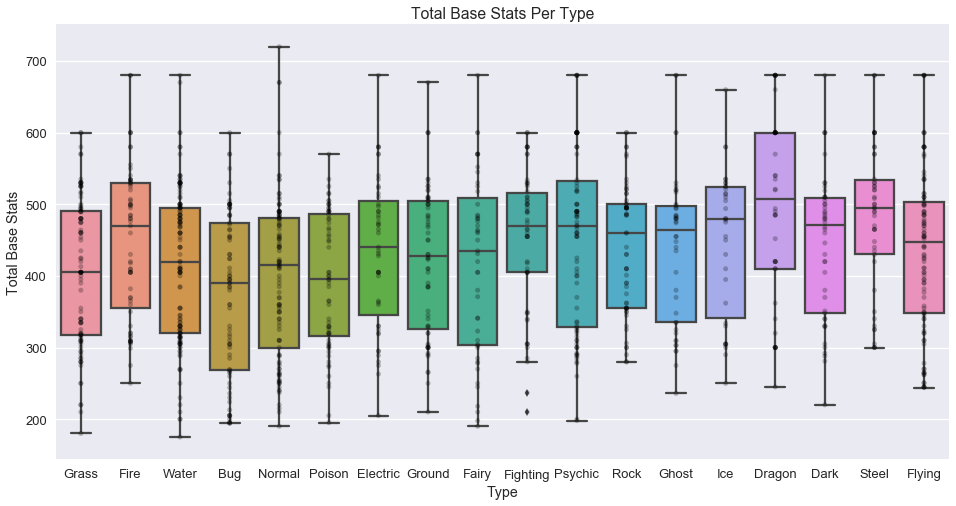

In [11]:
# Change the size of the plot to something more reasonable for viewing
sns.set(style="darkgrid", color_codes=False)
sns.set_context("talk", font_scale=1)
fig, ax = plt.subplots(figsize=(16,8))

# Plot the total base stats by type in a violin plot overlapped with a strip plot 
sns.boxplot(x="Type", y="Total", data=df3)
sns.stripplot(x="Type", y="Total", data=df3, color='k', alpha=.25)

plt.ylabel('Total Base Stats')
plt.title('Total Base Stats Per Type')
plt.show()

From this we can see that Dragon-type, Fighting-type, Steel-type Pokemon generally have high total base stats, with Dragon-type being the highest. The lower quartile for these types are all above 400, with the median of Dragon-type being above 500. In comparison, some of the weaker Pokemon types would be Grass-types, Bug-types, and Poison-type, with the median being about 400. Looking at the Dragon-type, you can there are few points within the box itself but are more concentrated at the ends of the quartile, meaning that even among the Dragon-type Pokemon, there is a split between the weak and the strong. Compare this to either the Flying-type or Normal-type which have a more clear and even distribution of points across the box.

### Catch Rate

Now let's look at the Catch Rate of each Pokemon based on their type. The Catch Rate represents the difficulty a player will face when attempting to capture a wild Pokemon (a wild Pokemon is one found naturally in the game without a current owner). Usually, if a Pokemon is rare (Legendary even), then they will be harder to catch, thus the Pokemon will have a lower catch rate. So naturally if a Pokemon is quite common, it will have a higher catch rate.

Let's look at another boxplot, this one representing Catch Rate per Type.

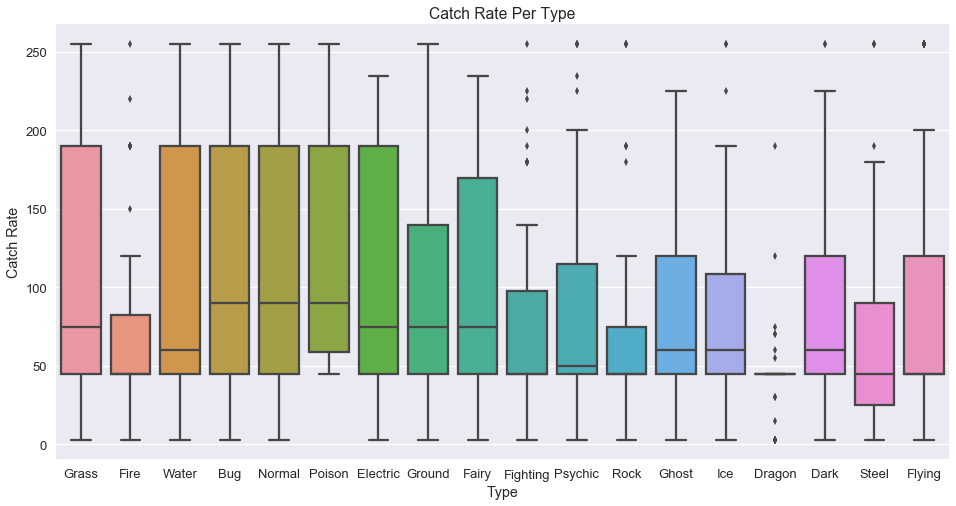

In [12]:
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,8))
sns.set_context("talk", font_scale=1)

# Plot a boxplot of Catch Rate by Type 
sns.boxplot(x="Type", y="Catch Rate", data=df3)

plt.title('Catch Rate Per Type')
plt.show()

As we can see, undoubtedly, the lowest catch rate of any Pokemon type would be the Dragon-type with the upper, middle and lower quartile all being about the same, other than a few outliers. We can conclude that Dragon-type Pokemon are the hardest wild Pokemon for a player to catch and may be harder to find. We can also see that Fire-type and Rock-type have no visible middle quartile and the box is small, so the range of the catch rate is small, and low, so the Pokemon of these types are relatively harder to catch. Note that the Steel-type Pokemon has a lower-quartile that is below all the others, while its middle matches with the others' lower-quartile. This means that other than Dragon-type Pokemon, Steel-type Pokemon have the lowest catch rate and are hard to catch. In comparison to these lower catch rates, we can see Bug-type, Normal-type, and Poison-type have the highest median and therefore, are the easiest to catch and may be more common.


It seems like the Pokemon types that had high Total Stats might also be Pokemon that have low Catch Rate. Let's plot them against each other and see if there are any noticable trends

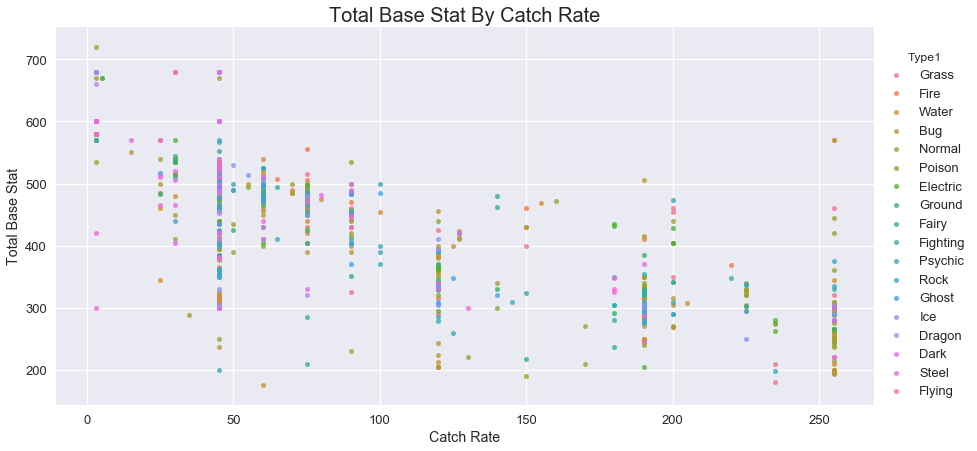

In [13]:
# Plot a lineplot of total base stat over catch rate
sns.lmplot(x='Catch Rate',y='Total', data=df, fit_reg=False, hue='Type1',\
           size= 6.25, aspect=2, scatter_kws={"s": 25})
# label and show plot
plt.title('Total Base Stat By Catch Rate', fontsize=20)
plt.ylabel('Total Base Stat')
plt.show()

#### It is evident that there is a trend, but let's plot a regression line to see the trend even more clearly.

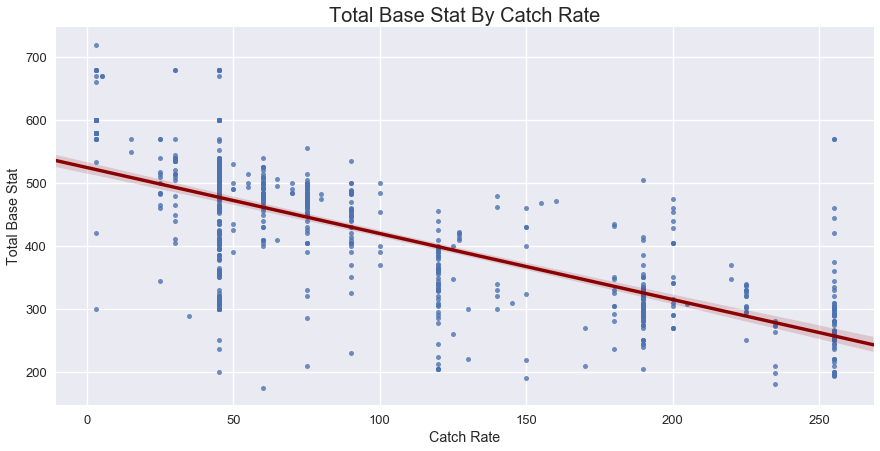

In [14]:
# using Seaborn,plot a 2-d polynomial regression on the scatter plot of total stats by catch rate with visual customizations
sns.lmplot(x='Catch Rate',y='Total', data=df,fit_reg=True, \
           size= 6.25, aspect=2, scatter_kws={"s": 25}, line_kws={'color':'darkred'}) # order=2,

# label and show plot
plt.title('Total Base Stat By Catch Rate', fontsize=20)
plt.ylabel('Total Base Stat')
plt.show()

Now that we have our polynomial regression line plotted, we can clearly see that there is a negative relationship between Pokemon's total base stats and their catch rate. This supports our assumption that a Pokemon's catch rate is dependant on their strength, meaning stronger Pokemon are harder to catch and weaker Pokemon are easier to catch.

Let's run an <a href="http://www.statsmodels.org/dev/examples/notebooks/generated/ols.html">Ordinary Least Squares</a> Regression on our data, so we can further examine the details of the regression.

In [15]:
regress = sm.OLS(df['Total'],df['Catch Rate']).fit()
print(regress.summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     598.2
Date:                Sat, 16 Dec 2017   Prob (F-statistic):           4.11e-99
Time:                        00:51:52   Log-Likelihood:                -5787.6
No. Observations:                 802   AIC:                         1.158e+04
Df Residuals:                     801   BIC:                         1.158e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Catch Rate     2.2850      0.093     24.458      0.0

The OLS Regression summary shows us a variety of results in regard to the regression, but we only want to examine the relevant details. The relevant details are the 'R-squared' and 'coef' values. The coefficient value shows the effect that our independent variable (catch rate in this case) has on the dependent variable (total stats), where the smaller the coefficient results in a smaller effect. The R-squared value is the fraction of the variation in the dependent variable that is accounted for by the independent variable. Typically, the closer the R-squared value is to 1, the more accurate our regression line would be, but as we can see by the graph, there are many points of data that would contribute to skewing the R-squared value even though there is an evident negative relation between the total stats and catch rate.

In [16]:
# look at the Pokemon with the lowest catch rate order in descending order 
df[df['Catch Rate'] < 5].sort_values(['Catch Rate','Total'], ascending=False).head()

,NatID,Name,Type1,Type2,Total,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Height (m),Weight (kg),Catch Rate,Male (%),Female (%),Egg Group 1,Egg Group 2
492,493,Arceus,Normal,None,720,120,120,120,120,120,120,4,3.20,320.0,3,0.0,0.0,Undiscovered,N/A
149,150,Mewtwo,Psychic,None,680,106,110,90,154,90,130,1,2.01,122.0,3,0.0,0.0,Undiscovered,N/A
248,249,Lugia,Psychic,Flying,680,106,90,130,90,154,110,2,5.21,216.0,3,0.0,0.0,Undiscovered,N/A
249,250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,3.81,199.0,3,0.0,0.0,Undiscovered,N/A
383,384,Rayquaza,Dragon,Flying,680,105,150,90,150,90,95,3,7.01,206.5,3,0.0,0.0,Undiscovered,N/A


The Pokemon that have the lowest catch rate have the highest total stats in our data, and these specific Pokemon noted above are actually Legendary Pokemon. Legendary Pokemon are the rarest and usually the strongest, so they will have the highest stats and lowest catch rates. On the contrary, the Pokemon who have the highest catch rates tend to also have the lowest base stats, and may be more common, allowing a player to catch easy Pokemon early in the game.

### Generation Analysis

Let's see if there is any correlation between the Generation a Pokemon was added to the Pokemon universe and their stats. There may be a trend where Pokemon added to newer generations have higher stats in general than previous generations.
First let's look at the amount of Pokemon there are in each generation seperated by their type by using a combination of a violinplot and stripplot.

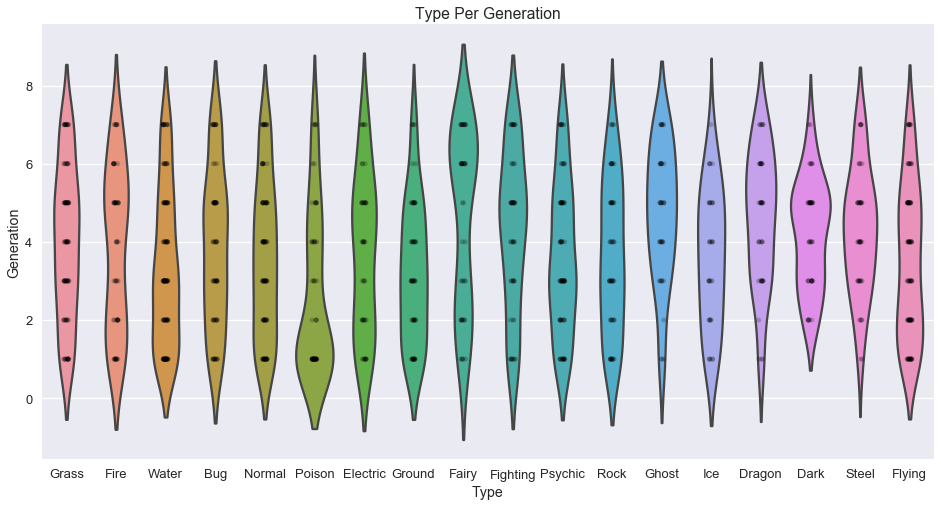

In [17]:
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,8))
sns.set_context("talk", font_scale=1)

# Plot each Pokemon on a plot of Total by Type1, colored by Generation 
sns.violinplot(x="Type", y="Generation", data=df3, inner=None)
sns.stripplot(x="Type", y="Generation", data=df3, color='k', alpha=.2, jitter=.05)

plt.title('Type Per Generation')
plt.show()

A violin plot shows where more points are concentrated by becoming wider in those areas. For example, looking at the violin for Poison-type Pokemon, we can see the majority of these Pokemon were introduced in the very first generation, since the violin seems to narrow as we go into newer generations. Compare this to Fairy-type, where the violin is widest around the sixth generation. This is further evidenced by the more opaque points in the wider regions and the more translucent points in the narrow regions. Additionally, Dark-type Pokemon have no values for the first generation, showing us that they were first introduced in the second generation, but most heavily in the fifth generation.

Now that we've taken a look at the generations with relation to types, let's see how they effect the total base stats of the Pokemon with respect to its type.

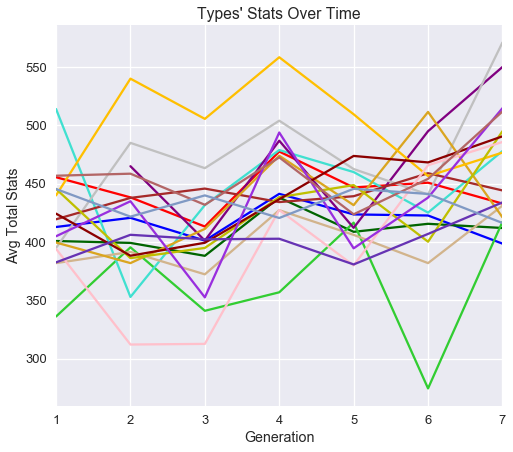

In [18]:
# filter the data grouping by types
type_normal = df[(df['Type1']=='Normal') | (df['Type2']=='Normal')]
type_fire = df[(df['Type1']=='Fire') | (df['Type2']=='Fire')]
type_water = df[(df['Type1']=='Water') | (df['Type2']=='Water')]
type_electric = df[(df['Type1']=='Electric') | (df['Type2']=='Electric')]
type_grass = df[(df['Type1']=='Grass') | (df['Type2']=='Grass')]
type_ice = df[(df['Type1']=='Ice') | (df['Type2']=='Ice')]
type_fighting = df[(df['Type1']=='Fighting') | (df['Type2']=='Fighting')]
type_poison = df[(df['Type1']=='Poison') | (df['Type2']=='Poison')]
type_ground = df[(df['Type1']=='Ground') | (df['Type2']=='Ground')]
type_flying = df[(df['Type1']=='Flying') | (df['Type2']=='Flying')]
type_psychic = df[(df['Type1']=='Psychic') | (df['Type2']=='Psychic')]
type_bug = df[(df['Type1']=='Bug') | (df['Type2']=='Bug')]
type_ghost =  df[(df['Type1']=='Ghost') | (df['Type2']=='Ghost')]
type_rock = df[(df['Type1']=='Rock') | (df['Type2']=='Rock')]
type_fairy = df[(df['Type1']=='Fairy') | (df['Type2']=='Fairy')]
type_steel = df[(df['Type1']=='Steel') | (df['Type2']=='Steel')]
type_dragon = df[(df['Type1']=='Dragon') | (df['Type2']=='Dragon')]
type_dark = df[(df['Type1']=='Dark') | (df['Type2']=='Dark')]

# group the types by generation and examine the total stats
fire_gen = type_fire.groupby('Generation')['Total'] 
water_gen = type_water.groupby('Generation')['Total'] 
grass_gen = type_grass.groupby('Generation')['Total']
normal_gen = type_normal.groupby('Generation')['Total']
bug_gen = type_bug.groupby('Generation')['Total']
ice_gen = type_ice.groupby('Generation')['Total']
dark_gen = type_dark.groupby('Generation')['Total']
steel_gen = type_steel.groupby('Generation')['Total']
rock_gen = type_rock.groupby('Generation')['Total']
ground_gen = type_ground.groupby('Generation')['Total']
dragon_gen = type_dragon.groupby('Generation')['Total']
electric_gen = type_electric.groupby('Generation')['Total']
fairy_gen = type_fairy.groupby('Generation')['Total']
fighting_gen = type_fighting.groupby('Generation')['Total']
ghost_gen = type_ghost.groupby('Generation')['Total']
poison_gen = type_poison.groupby('Generation')['Total']
psychic_gen = type_psychic.groupby('Generation')['Total']
flying_gen = type_flying.groupby('Generation')['Total']

# size of plot
plt.figure(figsize=(8,7))

# plot the average total stats over generation for each type (color-coded)
fire_gen.mean().plot(color='r')
water_gen.mean().plot(color='b')
grass_gen.mean().plot(color='darkgreen')
bug_gen.mean().plot(color='limegreen')
ice_gen.mean().plot(color='turquoise')
normal_gen.mean().plot(color='tan')
dark_gen.mean().plot(color='purple')
steel_gen.mean().plot(color='silver')
rock_gen.mean().plot(color='brown')
ground_gen.mean().plot(color='goldenrod')
dragon_gen.mean().plot(color=(1,.75,0))
electric_gen.mean().plot(color='y')
fairy_gen.mean().plot(color='pink')
fighting_gen.mean().plot(color='darkred')
ghost_gen.mean().plot(color=(.6,.18,.87))
poison_gen.mean().plot(color=(.4,.2,.7))
psychic_gen.mean().plot(color=(.7,.4,.4))
flying_gen.mean().plot(color=(.5,.6,.77))

# label and show plot
plt.ylabel("Avg Total Stats") 
plt.title("Types' Stats Over Time")
plt.show()

This graph displays the average total stats across the generations, with each line representing a different type. We can immediately infer from the graph that Bug-type Pokemon had the lowest average stats in generation 6, and that Dragon-type Pokemon were predominately the strongest Pokemon, having the highest stats for generations 2, 3, 4, and 5. We can see that Ice-type Pokemon, who had the highest stats for generation 1, dropped to the second lowest in generation 2 and never recovered their position as one of the strongest types. Also, in generation 7 we can see that Silver-type and Dark-type Pokemon have the highest total stats, with Silver-type setting a new record for having the highest average total stats across all the generations.

Let's visualize the same data in a more understandable manner, using bar graphs.

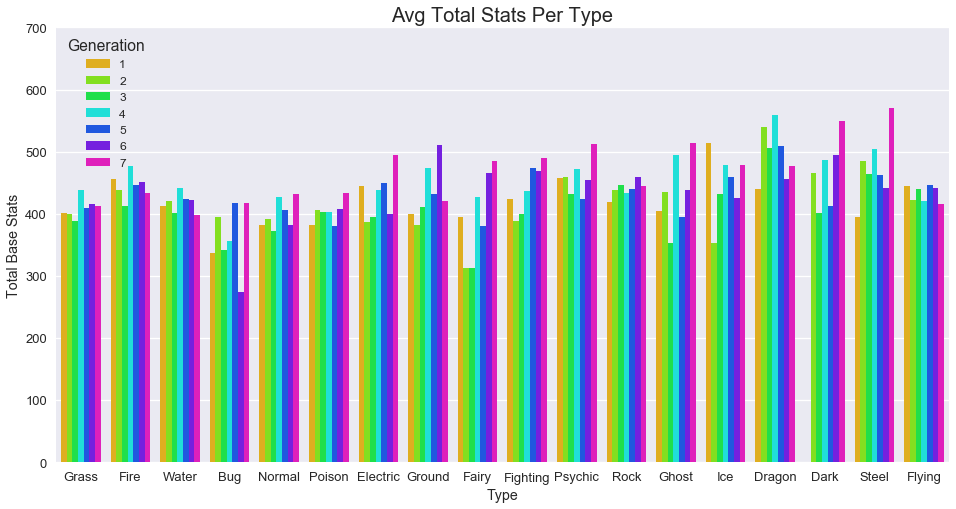

In [19]:
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,8))

# Plot each Pokemon on a plot of average total stats by type, colored by generation 
sns.barplot(x="Type", y="Total", data=df3, hue='Generation', errwidth=0, palette='hsv')

plt.ylabel('Total Base Stats')
plt.legend(title='Generation',loc=2,prop={'size':12})
plt.title('Avg Total Stats Per Type', fontsize=20)
plt.show()

There is a sizable amount of information to process here, with Dragon-type initially appearing to be the dominant type once again. It's clear that in generation 2 and 4, Dragon-type towers over the others, but not so much in generation 7. Generation 7 appears to feature stronger Pokemon of the Steel, Dark, and Psychic types. Fairy-type Pokemon also seemed to improve in generation 7 specifically when compared to generation 2 and 3, where they show the lowest stats on average. Again, we can see that in general that Bug-type Pokemon have lowest average total stats especially in generation 6.

However it's difficult to truly see the differences in the average stats for each type. Let's plot each of the average stats (HP, Attack, Defense, Special Attack, Special Defense, Speed) across the different types so we can see which types have the stats.

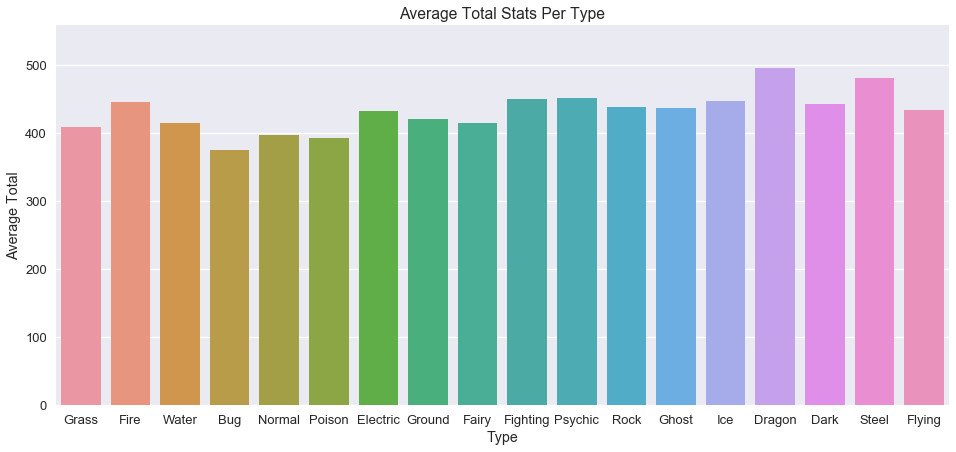

In [20]:
# TOTAL
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="Total", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Total')
plt.title('Average Total Stats Per Type')
plt.show()

#### Here we can see without a doubt just as we've seen in all of our previous graphs, Dragon-type Pokemon have the highest total base stats followed by Steel-type Pokemon, and Bug-type Pokemon have the lowest.

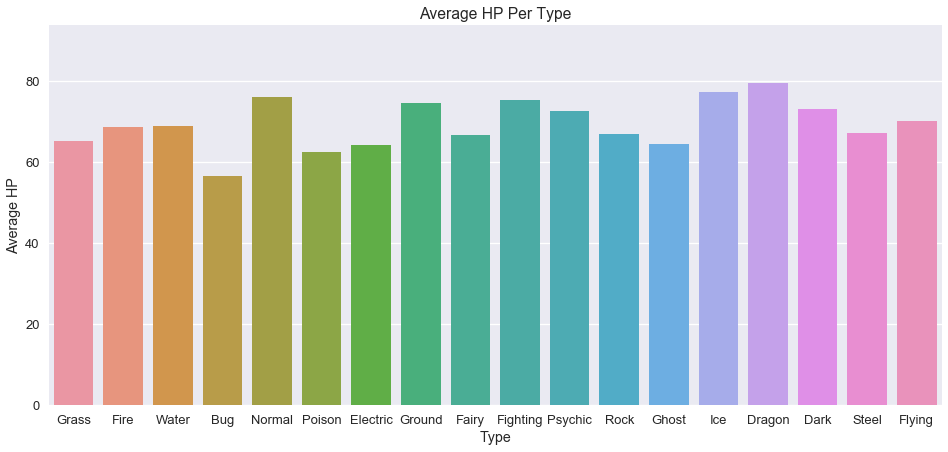

In [21]:
# HP
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="HP", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average HP')
plt.title('Average HP Per Type')
plt.show()

#### Here we can see Dragon-type Pokemon have the highest base HP followed by Ice-type Pokemon, and Bug-type Pokemon have the lowest again.

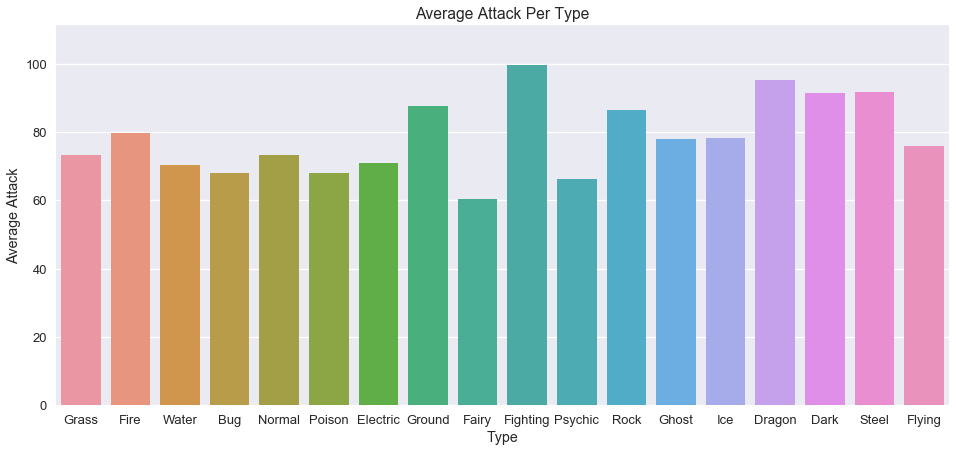

In [22]:
# Attack
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="Attack", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Attack')
plt.title('Average Attack Per Type')
plt.show()

#### Here we can see that this time Fighting-type Pokemon have the highest base Attack but are followed by Dragon-type Pokemon, and this time Fairy-type Pokemon have the lowest.

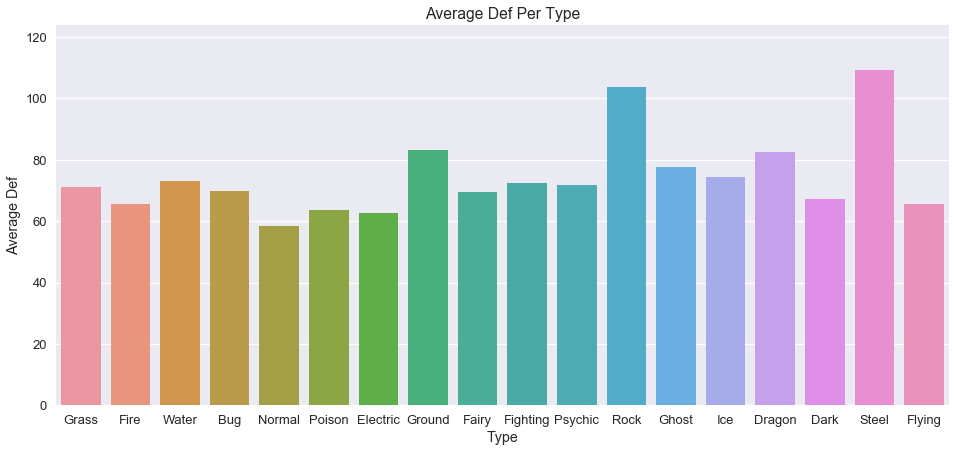

In [23]:
# Defense
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="Defense", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Def')
plt.title('Average Def Per Type')
plt.show()


#### Here we can see Steel-type Pokemon have the highest base Defense followed by Rock-type Pokemon, and Normal-type Pokemon have the lowest.

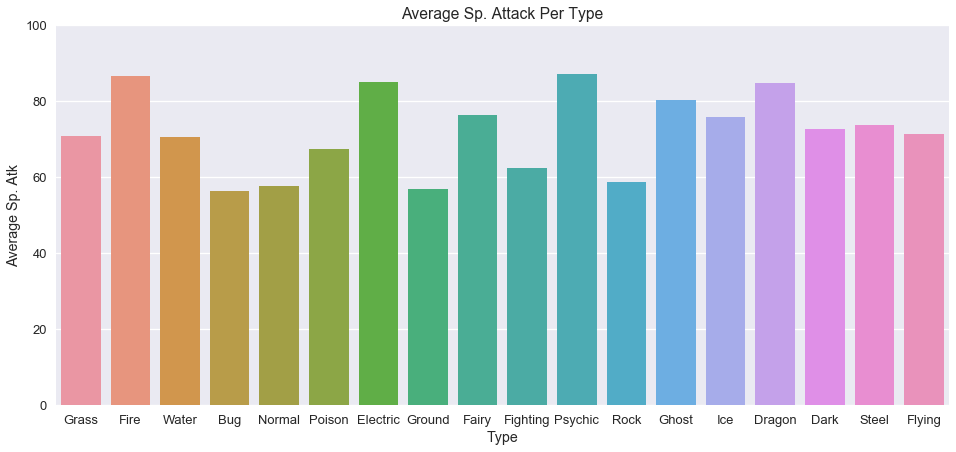

In [24]:
# Sp. Attack
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="SpAtk", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Sp. Atk')
plt.title('Average Sp. Attack Per Type')
plt.show()

#### Here we can see Psychic-type Pokemon have the highest base Special Attack, tied with Fire-type, followed by Electric-type Pokemon tied with Dragon-type Pokemon, and Bug-type Pokemon have the lowest again, tied with Ground-type.

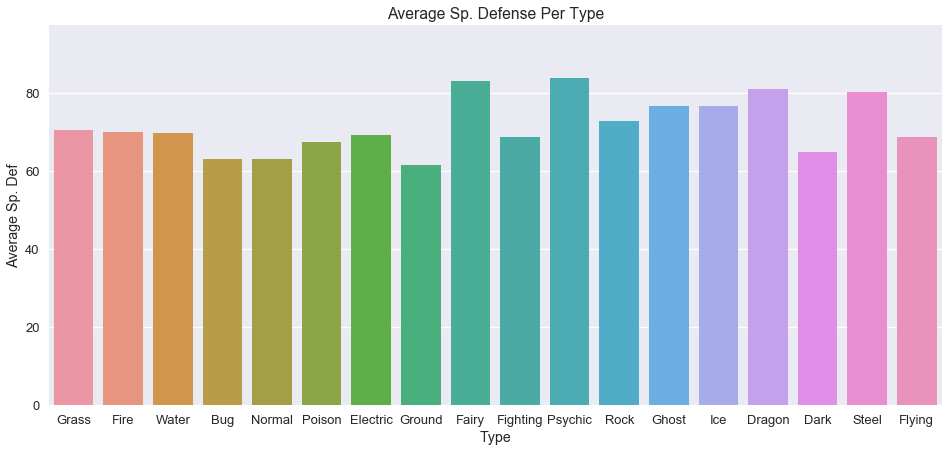

In [25]:
# Sp. Defense
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="SpDef", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Sp. Def')
plt.title('Average Sp. Defense Per Type')
plt.show()

#### Here we can see Psychic-type Pokemon have the highest base Special Defense, followed by Fairy-type Pokemon, and Ground-type Pokemon have the lowest.

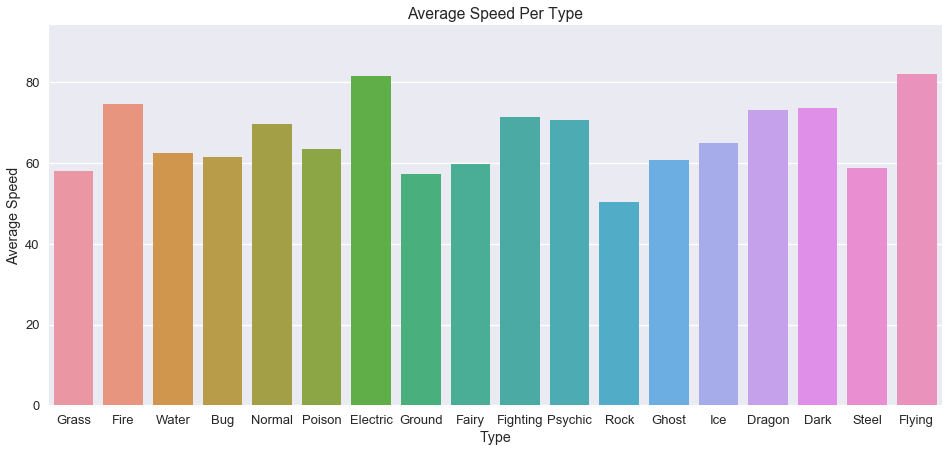

In [26]:
# Speed
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,7))

# plot the stat against type
sns.barplot(x="Type", y="Speed", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Speed')
plt.title('Average Speed Per Type')
plt.show()

#### Here we can see Flying-type Pokemon have the highest base Speed, tied with Electric-type Pokemon, followed by Fire-type Pokemon, and Rock-type Pokemon have the lowest.

### Height and Weight
We've look at graphs of each stat for all the Pokemon types, but Pokemon also have physical attributes such as height and weight. Let's see if we can find anything noteworthy by graphing height and weight across types.

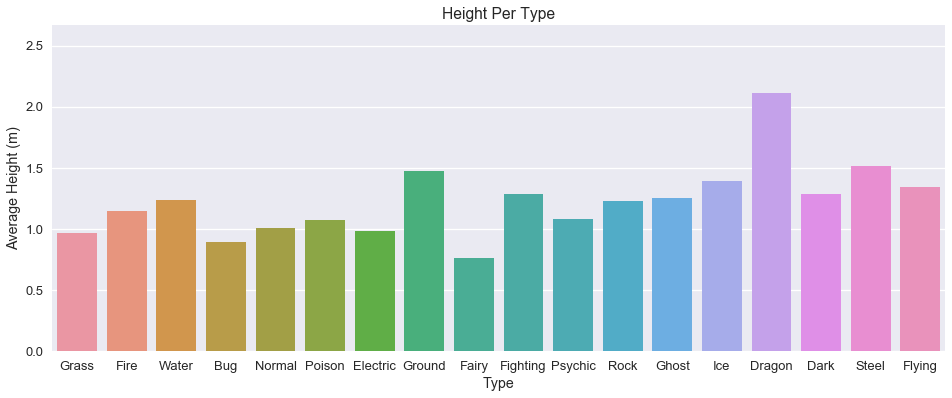

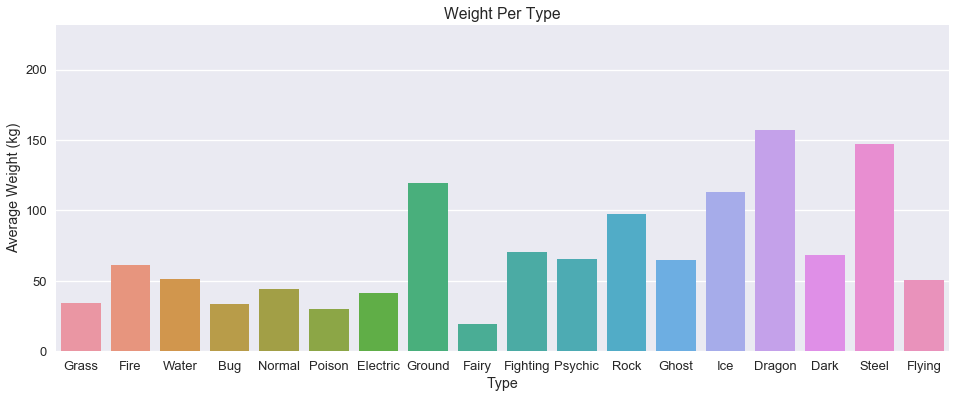

In [27]:
# Height
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,6))
sns.set_context("talk", font_scale=1)

# Plot Height by Type 
sns.barplot(x="Type", y="Height (m)", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Height (m)')
plt.title('Height Per Type')
plt.show()

# Weight
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,6))
sns.set_context("talk", font_scale=1)

# Plot Weight by Type 
sns.barplot(x="Type", y="Weight (kg)", data=df3, errwidth=0)

# adjust labels and plot
plt.ylabel('Average Weight (kg)')
plt.title('Weight Per Type')
plt.show()

The first graph shows the average height in meters of the Pokemon for each type, while the second graph shows the average weight in kilograms of the Pokemon for each type. We can see that the tallest Pokemon are starkly Dragon-type Pokemon, followed by Ground-type and Steel-type Pokemon. The smallest Pokemon are Fairy-type, and then Bug-type Pokemon. We can also that the heaviest Pokemon are Dragon-type, followed again by Steel-type and Ground-type Pokemon. The lightest Pokemon are once again Fairy-type, but followed by Poison-type Pokemon and Bug-type Pokemon not far behind.
We can conclude that the physcially biggest and heaviest Pokemon are primarily Dragon-type, and then Steel-type and Ground-type Pokemon, while the smallest and lightest Pokemon are Fairy-type, and then Bug-type Pokemon.

### Male and Female Genders
We've looked at the different base stats and now physical attributes. Now let's examine the Pokemon by their genders (Male and Female only...) for each type. Note that there are some Pokemon not accounted for in this part of the analysis because some Pokemon just don't have a gender, such as Legendary Pokemon.

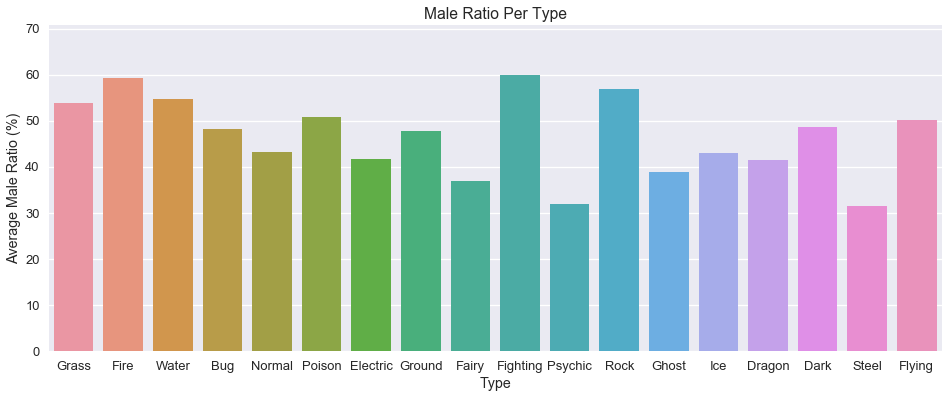

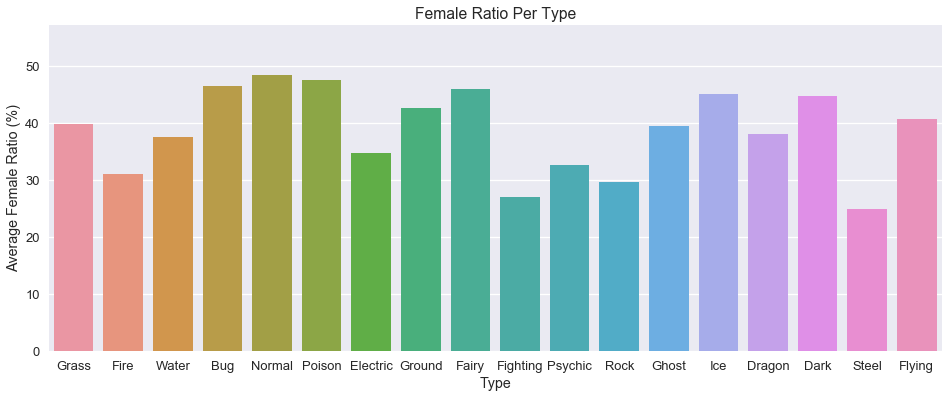

In [28]:
# Male Ratio
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,6))

# Plot Male Ratio by Type 
sns.barplot(x="Type", y="Male (%)", data=df3, errwidth=0)

plt.ylabel('Average Male Ratio (%)')
plt.title('Male Ratio Per Type')
plt.show()

# Female Ratio
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,6))

# Plot each Pokemon on a plot of Total by Type1, colored by Generation 
sns.barplot(x="Type", y="Female (%)", data=df3, errwidth=0)

plt.ylabel('Average Female Ratio (%)')
plt.title('Female Ratio Per Type')
plt.show()

The highest ratio of male Pokemon are Fighting-type, followed by Fire-type then Rock-type Pokemon, while the lowest is Steel-type and Psychic-type. The highest ratio of female Pokemon are Normal-type, followed by Poison-type then Bug-type tied with Fairy-type Pokemon. The lowest ratio of female Pokemon were also Steel-type, but then Fighting-type Pokemon.

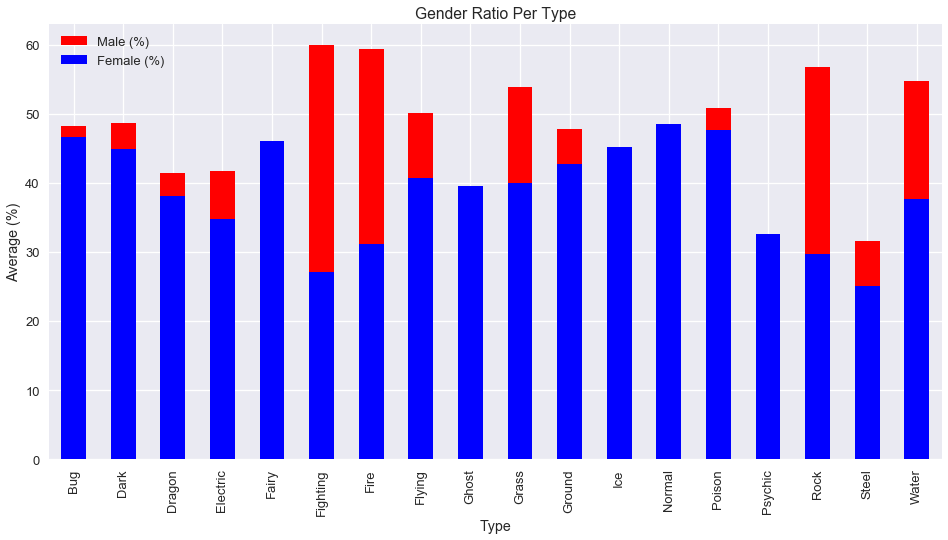

In [29]:
# Change the size of the plot to something more reasonable for viewing
fig, ax = plt.subplots(figsize=(16,8))

avg_f = df3.groupby('Type')['Female (%)'].mean()
avg_m = df3.groupby('Type')['Male (%)'].mean()

avg_m.plot(kind='bar',color='red', stacked=True)
avg_f.plot(kind='bar',color='blue', stacked=True)

# adjust labels and plot
plt.ylabel('Average (%)')
plt.xlabel('Type')
plt.title('Gender Ratio Per Type')
plt.legend()
plt.show()

This graph plots the female ratio on top of the male ratio of Pokemon for each type. The bars that are all blue show that type has a higher female ratio of Pokemon, such as Fairy-type and Normal-type. As we can see, only 5 out of 18 types have a higher female than male ratio, so we can conclude that the majority of Pokemon types have a greater chance of being a male Pokemon. There are types where the average ratio for male and female are very close, such as Bug-type and Poison-type.

<h2>Part 3: Machine Learning </h2>

The goal of machine learning for our purposes will be to predict the type of a Pokemon given its various other attributes. Our null hypothesis is that there is no significant correlation between a Pokemon's type and its other attributes. We will be training the algorithm with a set of the data and will test it with the remaining portion. This could be useful because there are a lot of fan base made Pokemon games. Often times, developers like to create there own Pokemon when making their own games. These develepors could input a set of attributes and then determine what type that Pokemon should be.

We will be using <a href="http://scikit-learn.org/stable/modules/cross_validation.html">K-Fold cross validation</a> and the will split the data into 10 roughly equal in size groups. The code is shown below.

In [30]:
# Convert the dataframe to a matrix, taking only the attributes we want 
X = df.as_matrix(["Total", "HP", "Attack", "Defense", "SpAtk", "SpDef", "Speed", "Height (m)", "Weight (kg)",\
                  "Catch Rate", "Male (%)", "Female (%)"])

# Convert the column of types from the original dataframe to another matrix
Y = df.as_matrix(["Type1"])

# Create a KFold object with 10 splits
kf = KFold(n_splits=10, shuffle=True)

<h3> K-Nearest Neighbors Model </h3>

The <a href="http://scikit-learn.org/stable/modules/neighbors.html">K-Nearest Neighbors Model</a> basically plots all of the attributes of a Pokemon onto a multi-dimensional graph. It then finds what type a Pokemon should be given its attributes by seeing which type appears most for the K-Nearest neighbors. First we will see which value of k will result in the best Zero-One loss value. A <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.zero_one_loss.html">Zero-One Loss function</a> will essentially tell us how successful the algorithm was in determining a Pokemon's type. A value close to 1 would mean that it was not very successful while a value close to 0 would mean that it was successful. We want to see what amount of neighbors gives us the lowest Zero-One loss value. Below is our code to do this with comments explaining what each line is doing.

In [31]:
# Start k at 1, and increment all the way up to 10
k = 1
for train_idx, test_idx in kf.split(X):
    
    # Create the train and test sets for both X and Y
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # Create the CLF object with the appropriate k value, and weight neighbors by distance
    clf = sklearn.neighbors.KNeighborsClassifier(k, weights='distance')
    
    # Fit the model
    clf.fit(X_train, Y_train.ravel())
    
    # Predict the types for the test data
    prediction = clf.predict(X_test)
    
    # Print the Zero-One Loss value for each k-value
    print(str(k) + " neighbors: " + str(sklearn.metrics.zero_one_loss(Y_test.ravel(),prediction)))
    
    # Increment K for next iteration
    k = k + 1

1 neighbors: 0.777777777778
2 neighbors: 0.79012345679
3 neighbors: 0.8125
4 neighbors: 0.75
5 neighbors: 0.725
6 neighbors: 0.8125
7 neighbors: 0.75
8 neighbors: 0.7625
9 neighbors: 0.7375
10 neighbors: 0.7875


After running the above code repeated times, we determined that 5 neighbors was consistantly giving us the best result. We will now use the value of k as 5 and run the test 10 times for each set and retrieve the average Zero-One loss value. The code is shown below with comments explaining each line.

In [35]:
# Create a variable to keep track of the total loss so it can be averaged later
total_loss = 0

# For each split, fit the model and test
for train_idx, test_idx in kf.split(X):
    
    # Create the train and test sets for both X and Y
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # Create the CLF object with the appropriate k value, and weight neighbors by distance
    clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')
    
    # Fit the model
    clf.fit(X_train, Y_train.ravel())
    
    # Predict the types for the test data
    prediction = clf.predict(X_test)
    
    # Add the Zero-One loss value to the total
    total_loss = total_loss + sklearn.metrics.zero_one_loss(Y_test.ravel(), prediction);
    
# Print the average Zero-One loss value
print("Average Zero-One loss value: " + str(total_loss/10)) 

Average Zero-One loss value: 0.743271604938


We consistantly get a value of around 0.75. This means that based on the attributes we provided to the algorithm, it is unable to accuratly guess the type of the pokemon. 

<h2>Decision Tree Classifier Model</h2>

We will use K-Fold cross validation to determine which height would be best for our <a href="http://scikit-learn.org/stable/modules/tree.html">decision tree classifier</a> (DTC) model. On every level of the tree, an attribute is chosen to be split on for the next level. Then training data is split into different branches based on the attribute that was chosen. The leaves of the tree give the classifications.


In [38]:
k = 1
for train_index, test_index in kf.split(X):
    # set the training and testing values based on index
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    
    clf = sklearn.tree.DecisionTreeClassifier(max_depth=k)
    clf.fit(X_train, Y_train.ravel())
    Z = clf.predict(X_test)

    print("Height of "+str(k)+": "+str(sklearn.metrics.zero_one_loss(Y_test.ravel(),Z)))
    k += 1

Height of 1: 0.901234567901
Height of 2: 0.814814814815
Height of 3: 0.775
Height of 4: 0.85
Height of 5: 0.7375
Height of 6: 0.8625
Height of 7: 0.7
Height of 8: 0.8125
Height of 9: 0.775
Height of 10: 0.825


Based on this cross validation it appears as though both a height of 8 appear to result in the smallest loss values. Because shorter trees may to result in less overfitting of the training data, we'll go with a height of 8 for our decision tree classifier model.

In [39]:
k = 8
total_loss = 0
dtc = sklearn.tree.DecisionTreeClassifier(max_depth=k)
for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]
    dtc = sklearn.tree.DecisionTreeClassifier(max_depth=k)
    dtc.fit(X_train, Y_train.ravel())
    Z = clf.predict(X_test)
    total_loss = total_loss + sklearn.metrics.zero_one_loss(Y_test.ravel(), Z);
print(total_loss/10)    

0.309182098765


The DTC model has a significantly lower loss than the KNN model. This is because decision tree classifiers are better at ignoring interference from attributes that don't contribute to the classification. KNNs regard all the attributes, while low-height decision trees can place an emphasis on more important features. For example, the gender columns are probably not indicative of a Pokemon's type, and the decision tree classifier disregards them in order to achieve a more accurate classification.

<h2>Conclusion</h2>

We've analyzed all the data that we've scraped from the Pokemon database, searching for patterns and trends for us to be able to support our hypothesis. We are able to see there are some notable patterns that emrged in our data, such as Dragon-type Pokemon being the tallest and heaviest as well as having the highest total base stats, or Bug-type being the opposite.

Our analysis of the data leads us to believe that we might be able to identify what type a given Pokemon would be based on its other attributes. However, while configuring our machine learning, the success rate of predicting a Pokemon's type based on its other attributes was surprisingly low.

Given the results from our explanatory analysis and evidence from our machine learning, it seems that we are unable to predict which type a given Pokemon will be based on its base stats, physical attributes, and gender with passable amounts of accuracy and certainty. Therefore, we failed at rejecting our null hypothesis.

<h2>Resources</h2>

Anaconda https://www.continuum.io <br>
Pokemon Database https://pokemondb.net/pokedex/all<br>
Pandas http://pandas.pydata.org <br>
Seaborn Data Visual https://seaborn.pydata.org/ <br>
Matplotlib http://matplotlib.org/contents.html <br>
Scikit-learn http://scikit-learn.org/stable/ <br>
K-Fold Cross-validation http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html